# Evaluating emulator performance based on EOF reconstruction

In [144]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt
import xarray as xr
from scipy import stats

In [2]:
var = ["GPP", "LHF"]
nvar = len(var)

Get landfrac from an existing PPE simulation (constant throughout simulations)

In [99]:
f_lf = nc.netcdf_file("/glade/scratch/kdagon/archive/hydro_ensemble_LHC_1/lnd/hist/hydro_ensemble_LHC_1.clm2.h0.0016-01.nc",'r', mmap=False)
lf = f_lf.variables['landfrac']
landfrac = lf[:]

Mask landfrac to account for netcdf FillValues

In [100]:
import numpy.ma as ma
landfrac_mask = ma.masked_where(landfrac > 1e34, landfrac) # sufficiently large to mask FillValues (~1e36)

Read in GPP outputdata (PPE results) including obs mask

In [101]:
f = nc.netcdf_file("../outputdata/outputdata_"+var[0]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[0]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]

Mask landfrac (again!) to match obs mask

In [102]:
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)

Perform SVD

In [103]:
i,j = np.nonzero(landfrac_mask_obs)
dr = d[:,i,j]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 721)
(100, 100) (100,) (100, 721)


Save GPP output

In [104]:
d_GPP = d
dr_GPP = dr
s_GPP = s
Vh_GPP = Vh

Truncate at 3 modes (>95% variance)

In [105]:
nmodes = 3

Reconstruct climatology based on first 3 modes

In [110]:
print(np.allclose(dr, np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])))
dr_recon = np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])
print(dr_recon.shape)
dr_recon_GPP = dr_recon
dr_recon_map = np.full((nens,nlat,nlon),np.nan)
dr_recon_map[:,i,j] = dr_recon
print(dr_recon_map.shape)
dr_recon_map_GPP = dr_recon_map

False
(100, 721)
(100, 46, 72)


Now read LHF

In [111]:
f = nc.netcdf_file("../outputdata/outputdata_"+var[1]+"_forSVD_100.nc",'r',mmap=False)
X = f.variables[var[1]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
i_ind,j_ind = np.nonzero(landfrac_mask_obs)
dr = d[:,i_ind,j_ind]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 722)
(100, 100) (100,) (100, 722)


Save LHF output

In [112]:
d_LHF = d
dr_LHF = dr
s_LHF = s
Vh_LHF = Vh

Reconstruct climatology from first 3 modes

In [113]:
print(np.allclose(dr, np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])))
dr_recon = np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])
print(dr_recon.shape)
dr_recon_LHF = dr_recon
dr_recon_map = np.full((nens,nlat,nlon),np.nan)
dr_recon_map[:,i_ind,j_ind] = dr_recon
print(dr_recon_map.shape)
dr_recon_map_LHF = dr_recon_map

False
(100, 722)
(100, 46, 72)


## Reconstructed Climatologies

In [14]:
# original model output (area-weighted, anomalies from ensemble mean)
print(d_GPP.shape)
# reconstructed based on first 3 modes
print(dr_recon_GPP.shape)

(100, 46, 72)
(100, 46, 72)


In [15]:
# original model output (area-weighted, anomalies from ensemble mean)
print(d_LHF.shape)
# reconstructed based on first 3 modes
print(dr_recon_LHF.shape)

(100, 46, 72)
(100, 46, 72)


Get NN predictions to compare

In [16]:
# Fix random seed for reproducibility
np.random.seed(9)

In [17]:
# Read in input array
inputdata = np.load(file="../lhc_100.npy", allow_pickle=True)

In [18]:
# Define skill metric
import keras.backend as K
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

In [19]:
# Load previously trained model
from keras.models import load_model
model_GPP = load_model('../emulators/NN_GPP_finalize_multi-dim.h5', 
    custom_objects={'mean_sq_err' :mean_sq_err})
model_LHF = load_model('../emulators/NN_LHF_finalize_multi-dim.h5',
    custom_objects={'mean_sq_err': mean_sq_err})

W0916 08:30:50.652136 140183455020800 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 08:30:50.666754 140183455020800 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 08:30:50.718271 140183455020800 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0916 08:30:50.718848 140183455020800 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:184: The name tf.ConfigProto 

In [20]:
# Make predictions
model_preds_GPP = model_GPP.predict(inputdata)
model_preds_LHF = model_LHF.predict(inputdata)

In [21]:
# this is equivalent to U[:,:nmodes]
model_preds_GPP.shape

(100, 3)

Reconstruct climatology from emulator predictions

In [22]:
NN_recon_GPP = np.dot(model_preds_GPP*s_GPP[:nmodes], Vh_GPP[:nmodes,:])
NN_recon_GPP.shape

(100, 721)

In [23]:
NN_recon_GPP_map = np.full((nens,nlat,nlon),np.nan)
NN_recon_GPP_map[:,i,j] = NN_recon_GPP
print(NN_recon_GPP_map.shape)

(100, 46, 72)


In [24]:
NN_recon_LHF = np.dot(model_preds_LHF*s_LHF[:nmodes], Vh_LHF[:nmodes,:])
NN_recon_LHF.shape

(100, 722)

In [25]:
NN_recon_LHF_map = np.full((nens,nlat,nlon),np.nan)
NN_recon_LHF_map[:,i_ind,j_ind] = NN_recon_LHF
print(NN_recon_LHF_map.shape)

(100, 46, 72)


## RMSE relative to observations

Read in obs files

In [26]:
f = nc.netcdf_file("../obs/obs_"+var[0]+"_4x5_anom_forSVD.nc",'r',mmap=False)
X = f.variables[var[0]]
do_GPP = X[:]
do_GPP.shape

(46, 72)

In [27]:
f = nc.netcdf_file("../obs/obs_"+var[1]+"_4x5_anom_forSVD.nc",'r',mmap=False)
X = f.variables[var[1]]
do_LHF = X[:]
do_LHF.shape

(46, 72)

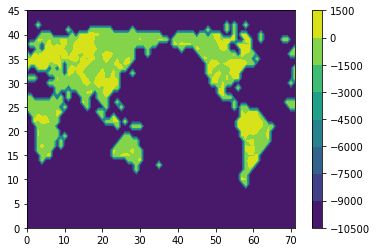

In [30]:
plt.contourf(do_GPP)
plt.colorbar()

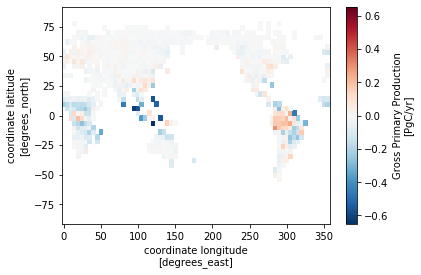

In [37]:
obs_GPP_forSVD = xr.open_dataset("../obs/obs_"+var[0]+"_4x5_anom_forSVD.nc")
obs_GPP_forSVD.GPP.plot()

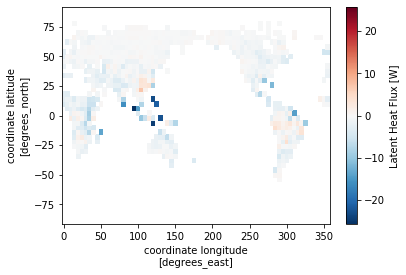

In [38]:
obs_LHF_forSVD = xr.open_dataset("../obs/obs_"+var[1]+"_4x5_anom_forSVD.nc")
obs_LHF_forSVD.LHF.plot()

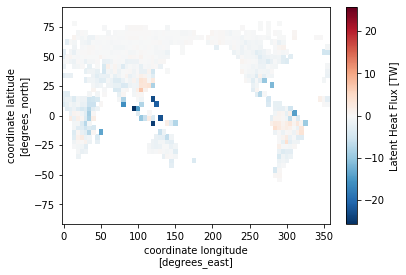

In [50]:
# sanity check the units are right
obs_LHF_forSVD_TW = xr.open_dataset("../obs/obs_"+var[1]+"_4x5_anom_forSVD_TW.nc")
obs_LHF_forSVD_TW.LHF.plot()
# same as above, original file just has the wrong metadata units for LHF

Read in PPE files

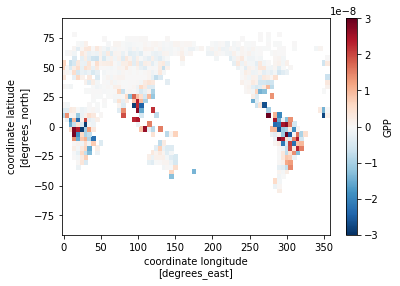

In [42]:
PPE_GPP_forSVD = xr.open_dataset("../outputdata/outputdata_"+var[0]+"_forSVD_100.nc")
PPE_GPP_forSVD.GPP.mean(dim='ens').plot() # mean values are small due to variation around 0 (anomalies from ensemble mean)

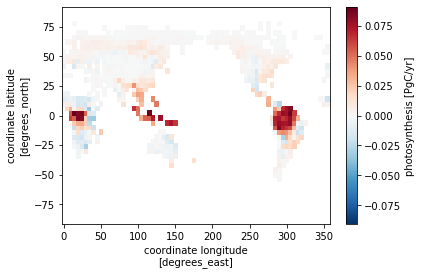

In [46]:
# random ensemble member
PPE_GPP_forSVD.GPP[8,:,:].plot()

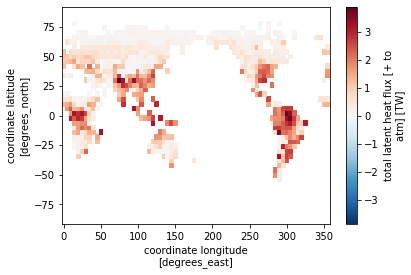

In [47]:
PPE_LHF_forSVD = xr.open_dataset("../outputdata/outputdata_"+var[1]+"_forSVD_100.nc")
PPE_LHF_forSVD.LHF[8,:,:].plot()

 Calculate RMSE across space for each ensemble member (PPE vs. obs)

In [51]:
from sklearn.metrics import mean_squared_error

In [53]:
PPE_GPP_forSVD.GPP.shape

(100, 46, 72)

In [90]:
nens = PPE_GPP_forSVD.GPP.shape[0]

100

In [68]:
# This command doesn't like the NaNs in the spatial maps
#MSE_GPP_PPE_obs = mean_squared_error(obs_GPP_forSVD.GPP, PPE_GPP_forSVD.GPP[0,:,:])
#RMSE_GPP_PPE_obs = np.sqrt(MSE_GPP_PPE_obs)

Try using the reshaped arrays that remove NaNs

In [75]:
dr_GPP.shape

(100, 721)

In [74]:
dr_LHF.shape

(100, 722)

Reshape the obs

In [76]:
dor_GPP = do_GPP[i,j]
dor_GPP.shape

(721,)

In [77]:
dor_LHF = do_LHF[i_ind,j_ind]
dor_LHF.shape

(722,)

RMSE of original PPE relative to observations

In [97]:
RMSE_GPP_PPE_obs = [np.sqrt(mean_squared_error(dor_GPP, dr_GPP[i,:])) for i in np.arange(nens)]
#RMSE_GPP_PPE_obs

In [98]:
RMSE_LHF_PPE_obs = [np.sqrt(mean_squared_error(dor_LHF, dr_LHF[i,:])) for i in np.arange(nens)]

RMSE of reconstructed PPE (3 modes) relative to observations

In [116]:
RMSE_GPP_PPErecon_obs = [np.sqrt(mean_squared_error(dor_GPP, dr_recon_GPP[i,:])) for i in np.arange(nens)]
RMSE_LHF_PPErecon_obs = [np.sqrt(mean_squared_error(dor_LHF, dr_recon_LHF[i,:])) for i in np.arange(nens)]

(0.08576269853115082, 0.12881470811367035)


Text(0.5, 1.0, 'GPP EOF Approximation')

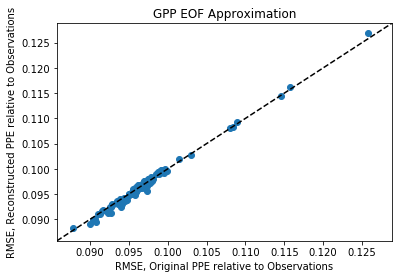

In [137]:
plt.scatter(RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs)
plt.xlabel('RMSE, Original PPE relative to Observations')
plt.ylabel('RMSE, Reconstructed PPE relative to Observations')
bounds = (np.amin([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])-0.002,np.amax([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])+0.002)
print(bounds)
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
plt.xlim(bounds)
plt.ylim(bounds)
plt.title("GPP EOF Approximation")
# Units here should be PgC/yr

(2.438759708404541, 4.188831901550293)


Text(0.5, 1.0, 'LHF EOF Approximation')

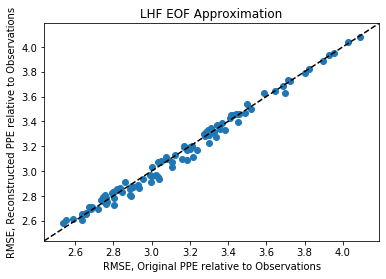

In [139]:
plt.scatter(RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs)
plt.xlabel('RMSE, Original PPE relative to Observations')
plt.ylabel('RMSE, Reconstructed PPE relative to Observations')
bounds = (np.amin([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])-0.1,np.amax([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])+0.1)
print(bounds)
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
plt.xlim(bounds)
plt.ylim(bounds)
plt.title("LHF EOF Approximation")
# Units here should be TW

RMSE of emulated PPE relative to observations

In [130]:
RMSE_GPP_NN_obs = [np.sqrt(mean_squared_error(dor_GPP, NN_recon_GPP[i,:])) for i in np.arange(nens)]
RMSE_LHF_NN_obs = [np.sqrt(mean_squared_error(dor_LHF, NN_recon_LHF[i,:])) for i in np.arange(nens)]

(0.08576269853115082, 0.12881470811367035)


Text(0.5, 1.0, 'GPP EOF Approximation and Emulation')

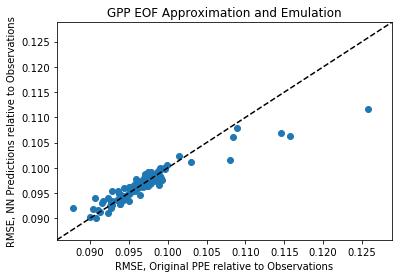

In [140]:
plt.scatter(RMSE_GPP_PPE_obs, RMSE_GPP_NN_obs)
plt.xlabel('RMSE, Original PPE relative to Observations')
plt.ylabel('RMSE, NN Predictions relative to Observations')
bounds = (np.amin([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])-0.002,np.amax([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])+0.002)
print(bounds)
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
plt.xlim(bounds)
plt.ylim(bounds)
plt.title("GPP EOF Approximation and Emulation")

(2.438759708404541, 4.188831901550293)


Text(0.5, 1.0, 'LHF EOF Approximation and Emulation')

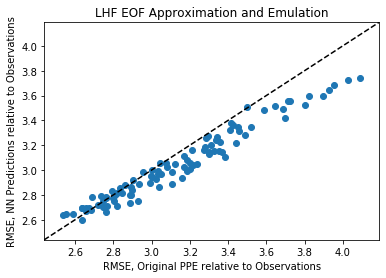

In [142]:
plt.scatter(RMSE_LHF_PPE_obs, RMSE_LHF_NN_obs)
plt.xlabel('RMSE, Original PPE relative to Observations')
plt.ylabel('RMSE, NN Predictions relative to Observations')
bounds = (np.amin([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])-0.1,np.amax([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])+0.1)
print(bounds)
plt.plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
plt.xlim(bounds)
plt.ylim(bounds)
plt.title("LHF EOF Approximation and Emulation")

All on one plot

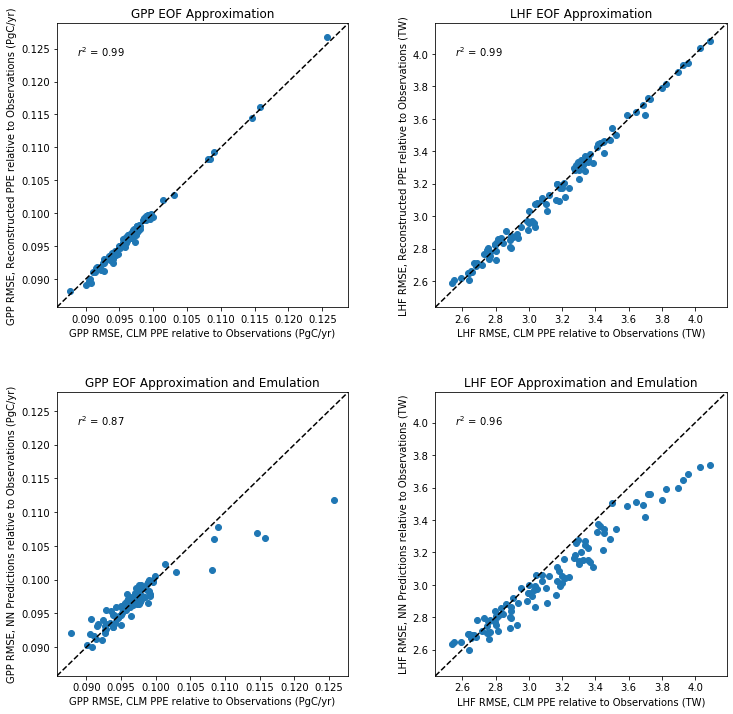

In [188]:
fig, axs = plt.subplots(2, nvar, figsize=(12,12))
axs = axs.ravel()

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[0].scatter(RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs)
axs[0].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[0].transAxes)
axs[0].set_xlabel('GPP RMSE, CLM PPE relative to Observations (PgC/yr)')
axs[0].set_ylabel('GPP RMSE, Reconstructed PPE relative to Observations (PgC/yr)')
axs[0].set_title("GPP EOF Approximation")
bounds = (np.amin([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])-0.002,np.amax([RMSE_GPP_PPE_obs, RMSE_GPP_PPErecon_obs])+0.002)
axs[0].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[0].set_xlim(bounds)
axs[0].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[1].scatter(RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs)
axs[1].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[1].transAxes)
axs[1].set_xlabel('LHF RMSE, CLM PPE relative to Observations (TW)')
axs[1].set_ylabel('LHF RMSE, Reconstructed PPE relative to Observations (TW)')
axs[1].set_title("LHF EOF Approximation")
bounds = (np.amin([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])-0.1,np.amax([RMSE_LHF_PPE_obs, RMSE_LHF_PPErecon_obs])+0.1)
axs[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[1].set_xlim(bounds)
axs[1].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_GPP_PPE_obs, RMSE_GPP_NN_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[2].scatter(RMSE_GPP_PPE_obs, RMSE_GPP_NN_obs)
axs[2].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[2].transAxes)
axs[2].set_xlabel('GPP RMSE, CLM PPE relative to Observations (PgC/yr)')
axs[2].set_ylabel('GPP RMSE, NN Predictions relative to Observations (PgC/yr)')
axs[2].set_title("GPP EOF Approximation and Emulation")
bounds = (np.amin([RMSE_GPP_PPE_obs, RMSE_GPP_NN_obs])-0.002,np.amax([RMSE_GPP_PPE_obs, RMSE_GPP_NN_obs])+0.002)
axs[2].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[2].set_xlim(bounds)
axs[2].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_LHF_PPE_obs, RMSE_LHF_NN_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[3].scatter(RMSE_LHF_PPE_obs, RMSE_LHF_NN_obs)
axs[3].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[3].transAxes)
axs[3].set_xlabel('LHF RMSE, CLM PPE relative to Observations (TW)')
axs[3].set_ylabel('LHF RMSE, NN Predictions relative to Observations (TW)')
axs[3].set_title("LHF EOF Approximation and Emulation")
bounds = (np.amin([RMSE_LHF_PPE_obs, RMSE_LHF_NN_obs])-0.1,np.amax([RMSE_LHF_PPE_obs, RMSE_LHF_NN_obs])+0.1)
axs[3].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[3].set_xlim(bounds)
axs[3].set_ylim(bounds);

plt.subplots_adjust(hspace=0.3,wspace=0.3)
#plt.savefig("validation_scatter_EOFandTotalError.pdf")

Large out-of-sample test: a second PPE

In [166]:
inputdata_v2 = np.load(file="../lhc_100_v2.npy", allow_pickle=True)

In [174]:
# GPP v2
f = nc.netcdf_file("../outputdata/outputdata_"+var[0]+"_forSVD_100_v2.nc",'r',mmap=False)
X = f.variables[var[0]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
i,j = np.nonzero(landfrac_mask_obs)
dr = d[:,i,j]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 721)
(100, 100) (100,) (100, 721)


Save GPP_v2 output

In [175]:
d_GPP_v2 = d
dr_GPP_v2 = dr
s_GPP_v2 = s
Vh_GPP_v2 = Vh

Reconstruct climatology from first 3 modes

In [178]:
print(np.allclose(dr, np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])))
dr_recon = np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])
print(dr_recon.shape)
dr_recon_GPP_v2 = dr_recon
dr_recon_map = np.full((nens,nlat,nlon),np.nan)
dr_recon_map[:,i,j] = dr_recon
print(dr_recon_map.shape)
dr_recon_map_GPP_v2 = dr_recon_map

False
(100, 721)
(100, 46, 72)


In [180]:
# LHF v2
f = nc.netcdf_file("../outputdata/outputdata_"+var[1]+"_forSVD_100_v2.nc",'r',mmap=False)
X = f.variables[var[1]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
landfrac_mask_obs = ma.masked_where(m==0, landfrac_mask)
i_ind,j_ind = np.nonzero(landfrac_mask_obs)
dr = d[:,i_ind,j_ind]
print(dr.shape)
U,s,Vh = np.linalg.svd(dr, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(100, 722)
(100, 100) (100,) (100, 722)


In [181]:
d_LHF_v2 = d
dr_LHF_v2 = dr
s_LHF_v2 = s
Vh_LHF_v2 = Vh

In [182]:
print(np.allclose(dr, np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])))
dr_recon = np.dot(U[:,:nmodes]*s[:nmodes], Vh[:nmodes,:])
print(dr_recon.shape)
dr_recon_LHF_v2 = dr_recon
dr_recon_map = np.full((nens,nlat,nlon),np.nan)
dr_recon_map[:,i_ind,j_ind] = dr_recon
print(dr_recon_map.shape)
dr_recon_map_LHF_v2 = dr_recon_map

False
(100, 722)
(100, 46, 72)


Emulator prediction

In [168]:
model_preds_GPP_v2 = model_GPP.predict(inputdata_v2)
model_preds_LHF_v2 = model_LHF.predict(inputdata_v2)

Reconstruct climatology from emulator predictions

In [183]:
NN_v2_recon_GPP = np.dot(model_preds_GPP_v2*s_GPP_v2[:nmodes], Vh_GPP_v2[:nmodes,:])
NN_v2_recon_GPP.shape

(100, 721)

In [184]:
NN_v2_recon_LHF = np.dot(model_preds_LHF_v2*s_LHF_v2[:nmodes], Vh_LHF_v2[:nmodes,:])
NN_v2_recon_LHF.shape

(100, 722)

RMSE of second PPE relative to observations

In [185]:
RMSE_GPP_v2_PPE_obs = [np.sqrt(mean_squared_error(dor_GPP, dr_GPP_v2[i,:])) for i in np.arange(nens)]
RMSE_LHF_v2_PPE_obs = [np.sqrt(mean_squared_error(dor_LHF, dr_LHF_v2[i,:])) for i in np.arange(nens)]

RMSE of reconstructed second PPE (3 modes) relative to observations

In [186]:
RMSE_GPP_v2_PPErecon_obs = [np.sqrt(mean_squared_error(dor_GPP, dr_recon_GPP_v2[i,:])) for i in np.arange(nens)]
RMSE_LHF_v2_PPErecon_obs = [np.sqrt(mean_squared_error(dor_LHF, dr_recon_LHF_v2[i,:])) for i in np.arange(nens)]

RMSE of emulated PPE relative to observations

In [187]:
RMSE_GPP_v2_NN_obs = [np.sqrt(mean_squared_error(dor_GPP, NN_v2_recon_GPP[i,:])) for i in np.arange(nens)]
RMSE_LHF_v2_NN_obs = [np.sqrt(mean_squared_error(dor_LHF, NN_v2_recon_LHF[i,:])) for i in np.arange(nens)]

All on one plot

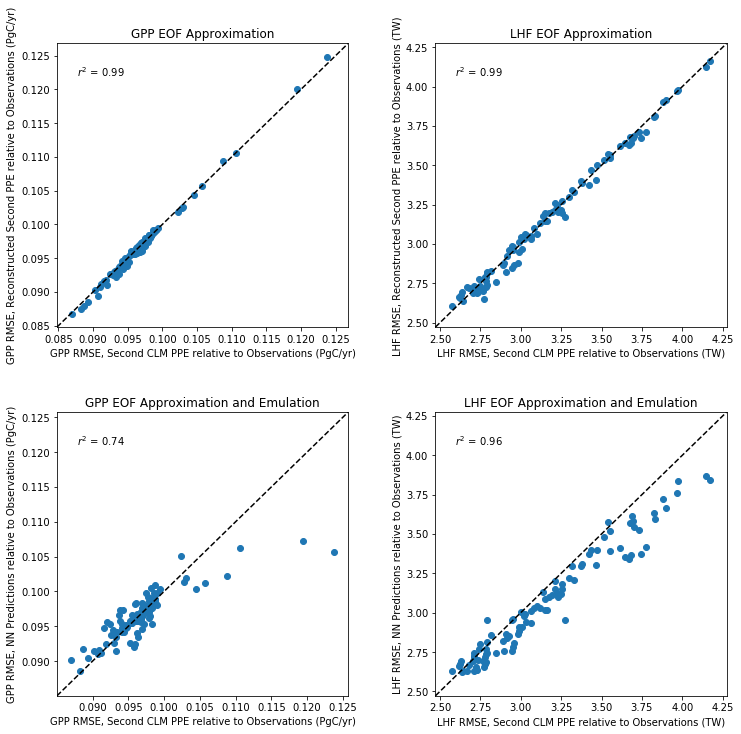

In [190]:
fig, axs = plt.subplots(2, nvar, figsize=(12,12))
axs = axs.ravel()

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_PPErecon_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[0].scatter(RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_PPErecon_obs)
axs[0].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[0].transAxes)
axs[0].set_xlabel('GPP RMSE, Second CLM PPE relative to Observations (PgC/yr)')
axs[0].set_ylabel('GPP RMSE, Reconstructed Second PPE relative to Observations (PgC/yr)')
axs[0].set_title("GPP EOF Approximation")
bounds = (np.amin([RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_PPErecon_obs])-0.002,np.amax([RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_PPErecon_obs])+0.002)
axs[0].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[0].set_xlim(bounds)
axs[0].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_PPErecon_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[1].scatter(RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_PPErecon_obs)
axs[1].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[1].transAxes)
axs[1].set_xlabel('LHF RMSE, Second CLM PPE relative to Observations (TW)')
axs[1].set_ylabel('LHF RMSE, Reconstructed Second PPE relative to Observations (TW)')
axs[1].set_title("LHF EOF Approximation")
bounds = (np.amin([RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_PPErecon_obs])-0.1,np.amax([RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_PPErecon_obs])+0.1)
axs[1].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[1].set_xlim(bounds)
axs[1].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_NN_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[2].scatter(RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_NN_obs)
axs[2].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[2].transAxes)
axs[2].set_xlabel('GPP RMSE, Second CLM PPE relative to Observations (PgC/yr)')
axs[2].set_ylabel('GPP RMSE, NN Predictions relative to Observations (PgC/yr)')
axs[2].set_title("GPP EOF Approximation and Emulation")
bounds = (np.amin([RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_NN_obs])-0.002,np.amax([RMSE_GPP_v2_PPE_obs, RMSE_GPP_v2_NN_obs])+0.002)
axs[2].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[2].set_xlim(bounds)
axs[2].set_ylim(bounds)

slope, intercept, r_value, p_value, std_err = stats.linregress(RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_NN_obs)
pltstr = "$r^2$ = %.2g" % r_value**2
axs[3].scatter(RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_NN_obs)
axs[3].text(0.15, 0.9, pltstr, horizontalalignment='center', verticalalignment='center', 
            transform=axs[3].transAxes)
axs[3].set_xlabel('LHF RMSE, Second CLM PPE relative to Observations (TW)')
axs[3].set_ylabel('LHF RMSE, NN Predictions relative to Observations (TW)')
axs[3].set_title("LHF EOF Approximation and Emulation")
bounds = (np.amin([RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_NN_obs])-0.1,np.amax([RMSE_LHF_v2_PPE_obs, RMSE_LHF_v2_NN_obs])+0.1)
axs[3].plot([bounds[0], bounds[1]], [bounds[0], bounds[1]], 'k--', color = 'k')
axs[3].set_xlim(bounds)
axs[3].set_ylim(bounds);

plt.subplots_adjust(hspace=0.3,wspace=0.3)
#plt.savefig("validation_scatter_EOFandTotalError_OOS.pdf")